# Task 1: Machine Learning Problem
The problem I'm solving using Logistic Regression is whether an NBA player will be inducted into the Hall of Fame. This problem is best solved using Logistic Regression because the solution involves predicting a probability, which is the purpose of Logistic Regression. Other classification models may be able to predict the class of an NBA player (Hall of Famer or not), but probabilities are more applicable to this problem due to the induction of a player into the Hall of Fame being mostly subjective in the end.


In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

# Task 2: Data Manipulation
The model uses data from multiple data sets since there was no singular data set relevant to the NBA containing both information about players and their Hall of Fame status. <br>
Links:
 - [NBA Players](https://www.kaggle.com/datasets/justinas/nba-players-data)</li>
 - [NBA Hall of Famers 2021](https://www.kaggle.com/datasets/simplyab/nba-hall-of-famers-as-for-2021)

Exploratory Data Analysis (EDA) processes are shown in later cells, along with their descriptions and justifications.


## Load data

In [2]:
temp_player_data = pd.read_csv('/content/all_seasons.csv')
temp_hof_data = pd.read_csv('/content/NBA Hall of Famers 2021.csv')

In [3]:
predict_label = 'In_Hall_of_fame'

In [4]:
# Maybe conduct EDA on the columns being dropped
# Ensure no harm done to model by removing columns

player_data = temp_player_data.drop(columns=['Unnamed: 0', 'age', 'player_height', 'player_weight', 'country', 'season'])
hof_data = temp_hof_data.drop(columns=['position', 'height', 'weight', 'born'])

In [5]:
player_data.head()

,player_name,team_abbreviation,college,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
0,Dennis Rodman,CHI,Southeastern Oklahoma State,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113
1,Dwayne Schintzius,LAC,Florida,1990,1,24,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048
2,Earl Cureton,TOR,Detroit Mercy,1979,3,58,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148
3,Ed O'Bannon,DAL,UCLA,1995,1,9,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077
4,Ed Pinckney,MIA,Villanova,1985,1,10,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040


In [6]:
hof_data.head()

,Name,All_star_selections,In_Hall_of_fame
0,Kareem Abdul-Jabbar,19,1
1,Kobe Bryant,18,1
2,LeBron James,17,2
3,Tim Duncan,15,1
4,Kevin Garnett,15,1


## Pre-EDA: Null-value analysis
Checking each data set for null values helps determine the correct method to merge them together. In addition, entries with too many null values can be eliminated, and entries with few null values can be filled manually. Luckily, this process revealed that there are no null values in either data set, so the merge was seamless.

In [7]:
hof_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name                 437 non-null    object
 1   All_star_selections  437 non-null    int64 
 2   In_Hall_of_fame      437 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.4+ KB


In [8]:
player_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12305 non-null  object 
 1   team_abbreviation  12305 non-null  object 
 2   college            12305 non-null  object 
 3   draft_year         12305 non-null  object 
 4   draft_round        12305 non-null  object 
 5   draft_number       12305 non-null  object 
 6   gp                 12305 non-null  int64  
 7   pts                12305 non-null  float64
 8   reb                12305 non-null  float64
 9   ast                12305 non-null  float64
 10  net_rating         12305 non-null  float64
 11  oreb_pct           12305 non-null  float64
 12  dreb_pct           12305 non-null  float64
 13  usg_pct            12305 non-null  float64
 14  ts_pct             12305 non-null  float64
 15  ast_pct            12305 non-null  float64
dtypes: float64(9), int64(1

## Data pre-processing
Group player data by each player and merge with HOF data

In [ ]:
player_data[player_data['player_name'] == 'Dennis Rodman']

,player_name,team_abbreviation,college,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
0,Dennis Rodman,CHI,Southeastern Oklahoma State,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113
728,Dennis Rodman,CHI,Southeastern Oklahoma State,1986,2,27,80,4.7,15.0,2.9,6.7,0.169,0.319,0.088,0.459,0.112
1227,Dennis Rodman,LAL,Southeastern Oklahoma State,1986,2,27,23,2.1,11.2,1.3,-1.4,0.114,0.348,0.065,0.388,0.063
1354,Dennis Rodman,DAL,Southeastern Oklahoma State,1986,2,27,12,2.8,14.3,1.2,-7.1,0.136,0.351,0.064,0.457,0.046


In [7]:
def column_agg(x):
    d = {}
    d['team'] = x['team_abbreviation'].mode().iloc[0]
    d['college'] = x['college'].iloc[0]
    d['draft'] = -1 if x['draft_year'].iloc[0] == 'Undrafted' else x['draft_number'].iloc[0]
    games = x['gp'].sum()
    d['gp'] = games
    convertStat = lambda stat: round((stat * x['gp']).sum() / games, 2)
    d['pts'] = convertStat(x['pts'])
    d['reb'] = convertStat(x['reb'])
    d['ast'] = convertStat(x['ast'])
    d['net_rating'] = convertStat(x['net_rating'])
    d['oreb_pct'] = convertStat(x['oreb_pct'])
    d['dreb_pct'] = convertStat(x['dreb_pct'])
    d['usg_pct'] = convertStat(x['usg_pct'])
    d['ts_pct'] = convertStat(x['ts_pct'])
    d['ast_pct'] = convertStat(x['ast_pct'])
    return pd.Series(d, index=['team', 'college', 'draft', 'gp', 'pts', 'reb',
                               'ast', 'net_rating', 'oreb_pct', 'dreb_pct',
                               'usg_pct', 'ts_pct', 'ast_pct'])

In [8]:
player_groups = player_data.groupby('player_name').apply(column_agg)
player_groups.head()

,team,college,draft,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
player_name,,,,,,,,,,,,,
A.C. Green,DAL,Oregon State,23,379,5.86,6.19,0.89,-1.58,0.09,0.19,0.13,0.49,0.05
A.J. Bramlett,CLE,Arizona,39,8,1.00,2.80,0.00,-32.60,0.16,0.21,0.15,0.19,0.00
A.J. Guyton,CHI,Indiana,32,80,5.51,1.02,1.82,-7.35,0.02,0.06,0.20,0.47,0.23
AJ Hammons,DAL,Purdue,46,22,2.20,1.60,0.20,-0.60,0.05,0.20,0.17,0.47,0.04
AJ Price,IND,Connecticut,52,261,5.83,1.45,2.19,-1.28,0.02,0.09,0.21,0.48,0.25


In [9]:
hof_data = hof_data.rename(columns={'Name': 'player_name'})
merge_data = player_groups.merge(hof_data, on='player_name', how='inner')
merge_data.head()

,player_name,team,college,draft,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,All_star_selections,In_Hall_of_fame
0,A.C. Green,DAL,Oregon State,23,379,5.86,6.19,0.89,-1.58,0.09,0.19,0.13,0.49,0.05,1,0
1,Al Horford,ATL,Florida,3,950,13.67,8.18,3.31,4.03,0.07,0.21,0.19,0.57,0.16,5,2
2,Allan Houston,NYK,Tennessee,11,602,18.56,3.06,2.45,0.58,0.01,0.09,0.25,0.54,0.13,2,0
3,Allen Iverson,PHI,Georgetown,1,914,26.67,3.71,6.15,0.74,0.02,0.08,0.31,0.52,0.28,11,1
4,Alonzo Mourning,MIA,Georgetown,2,553,14.68,7.63,0.94,5.40,0.10,0.20,0.24,0.58,0.06,7,1


In [10]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_name          212 non-null    object 
 1   team                 212 non-null    object 
 2   college              212 non-null    object 
 3   draft                212 non-null    object 
 4   gp                   212 non-null    int64  
 5   pts                  212 non-null    float64
 6   reb                  212 non-null    float64
 7   ast                  212 non-null    float64
 8   net_rating           212 non-null    float64
 9   oreb_pct             212 non-null    float64
 10  dreb_pct             212 non-null    float64
 11  usg_pct              212 non-null    float64
 12  ts_pct               212 non-null    float64
 13  ast_pct              212 non-null    float64
 14  All_star_selections  212 non-null    int64  
 15  In_Hall_of_fame      212 non-null    int

In [11]:
# Only keep inactive players (active players may or may not become HOFs)
# Label encoding done to convert categorical features to numbers
le = preprocessing.LabelEncoder()

final_data = merge_data[merge_data['In_Hall_of_fame'] < 2]

final_data['team'] = le.fit_transform(final_data['team'])

final_data['draft'] = final_data['draft'].astype(int)
max_draft = max(final_data['draft'])
final_data['draft'] = final_data['draft'].apply(lambda x: abs(x - max_draft) if x > -1 else -1)

final_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,player_name,team,college,draft,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,All_star_selections,In_Hall_of_fame
0,A.C. Green,6,Oregon State,34,379,5.86,6.19,0.89,-1.58,0.09,0.19,0.13,0.49,0.05,1,0
2,Allan Houston,20,Tennessee,46,602,18.56,3.06,2.45,0.58,0.01,0.09,0.25,0.54,0.13,2,0
3,Allen Iverson,22,Georgetown,56,914,26.67,3.71,6.15,0.74,0.02,0.08,0.31,0.52,0.28,11,1
4,Alonzo Mourning,15,Georgetown,55,553,14.68,7.63,0.94,5.40,0.10,0.20,0.24,0.58,0.06,7,1
5,Amar'e Stoudemire,23,None,48,846,18.91,7.84,1.24,2.37,0.09,0.20,0.26,0.60,0.07,6,0


## Exploratory Data Analysis (EDA)

In [ ]:
# Possible EDA methods (from class example):
# info(), describe(), pairplot, scatter plot, pie chart, bar chart, histogram,
# grouping, PCA (not from class)

### Description of Data
This provides general statistics for each column in the data, which gives further insights on the number of values and the distributions of the features.

In [14]:
final_data.describe()

,team,draft,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,All_star_selections,In_Hall_of_fame
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,15.648649,42.804054,651.236486,13.579122,5.563851,2.972770,1.562703,0.060473,0.155676,0.215676,0.534122,0.161216,3.932432,0.243243
std,9.011606,14.089924,361.940863,4.758926,2.592176,1.975245,4.868963,0.036818,0.056715,0.043002,0.037178,0.092287,3.909977,0.430498
min,0.000000,-1.000000,13.000000,1.940000,1.230000,0.280000,-32.380000,0.010000,0.060000,0.090000,0.350000,0.040000,1.000000,0.000000
25%,8.000000,38.000000,371.000000,10.580000,3.485000,1.547500,-0.310000,0.030000,0.100000,0.190000,0.510000,0.090000,1.000000,0.000000
50%,15.000000,48.000000,621.500000,13.565000,5.490000,2.395000,1.720000,0.050000,0.150000,0.215000,0.530000,0.130000,2.000000,0.000000
75%,23.000000,53.000000,894.250000,16.735000,7.522500,3.922500,3.897500,0.090000,0.200000,0.250000,0.552500,0.202500,6.000000,0.000000
max,31.000000,56.000000,1541.000000,26.670000,14.790000,8.710000,14.900000,0.180000,0.330000,0.330000,0.630000,0.450000,18.000000,1.000000


### Pairplot
This shows one-to-one correlations between each of the features, along with the distribution of the prediction label (Hall of Famer) for each correlation. Detecting direct correlations between features is especially important when using Logistic Regression, since the algorithm is less accurate when significant correlations exist.

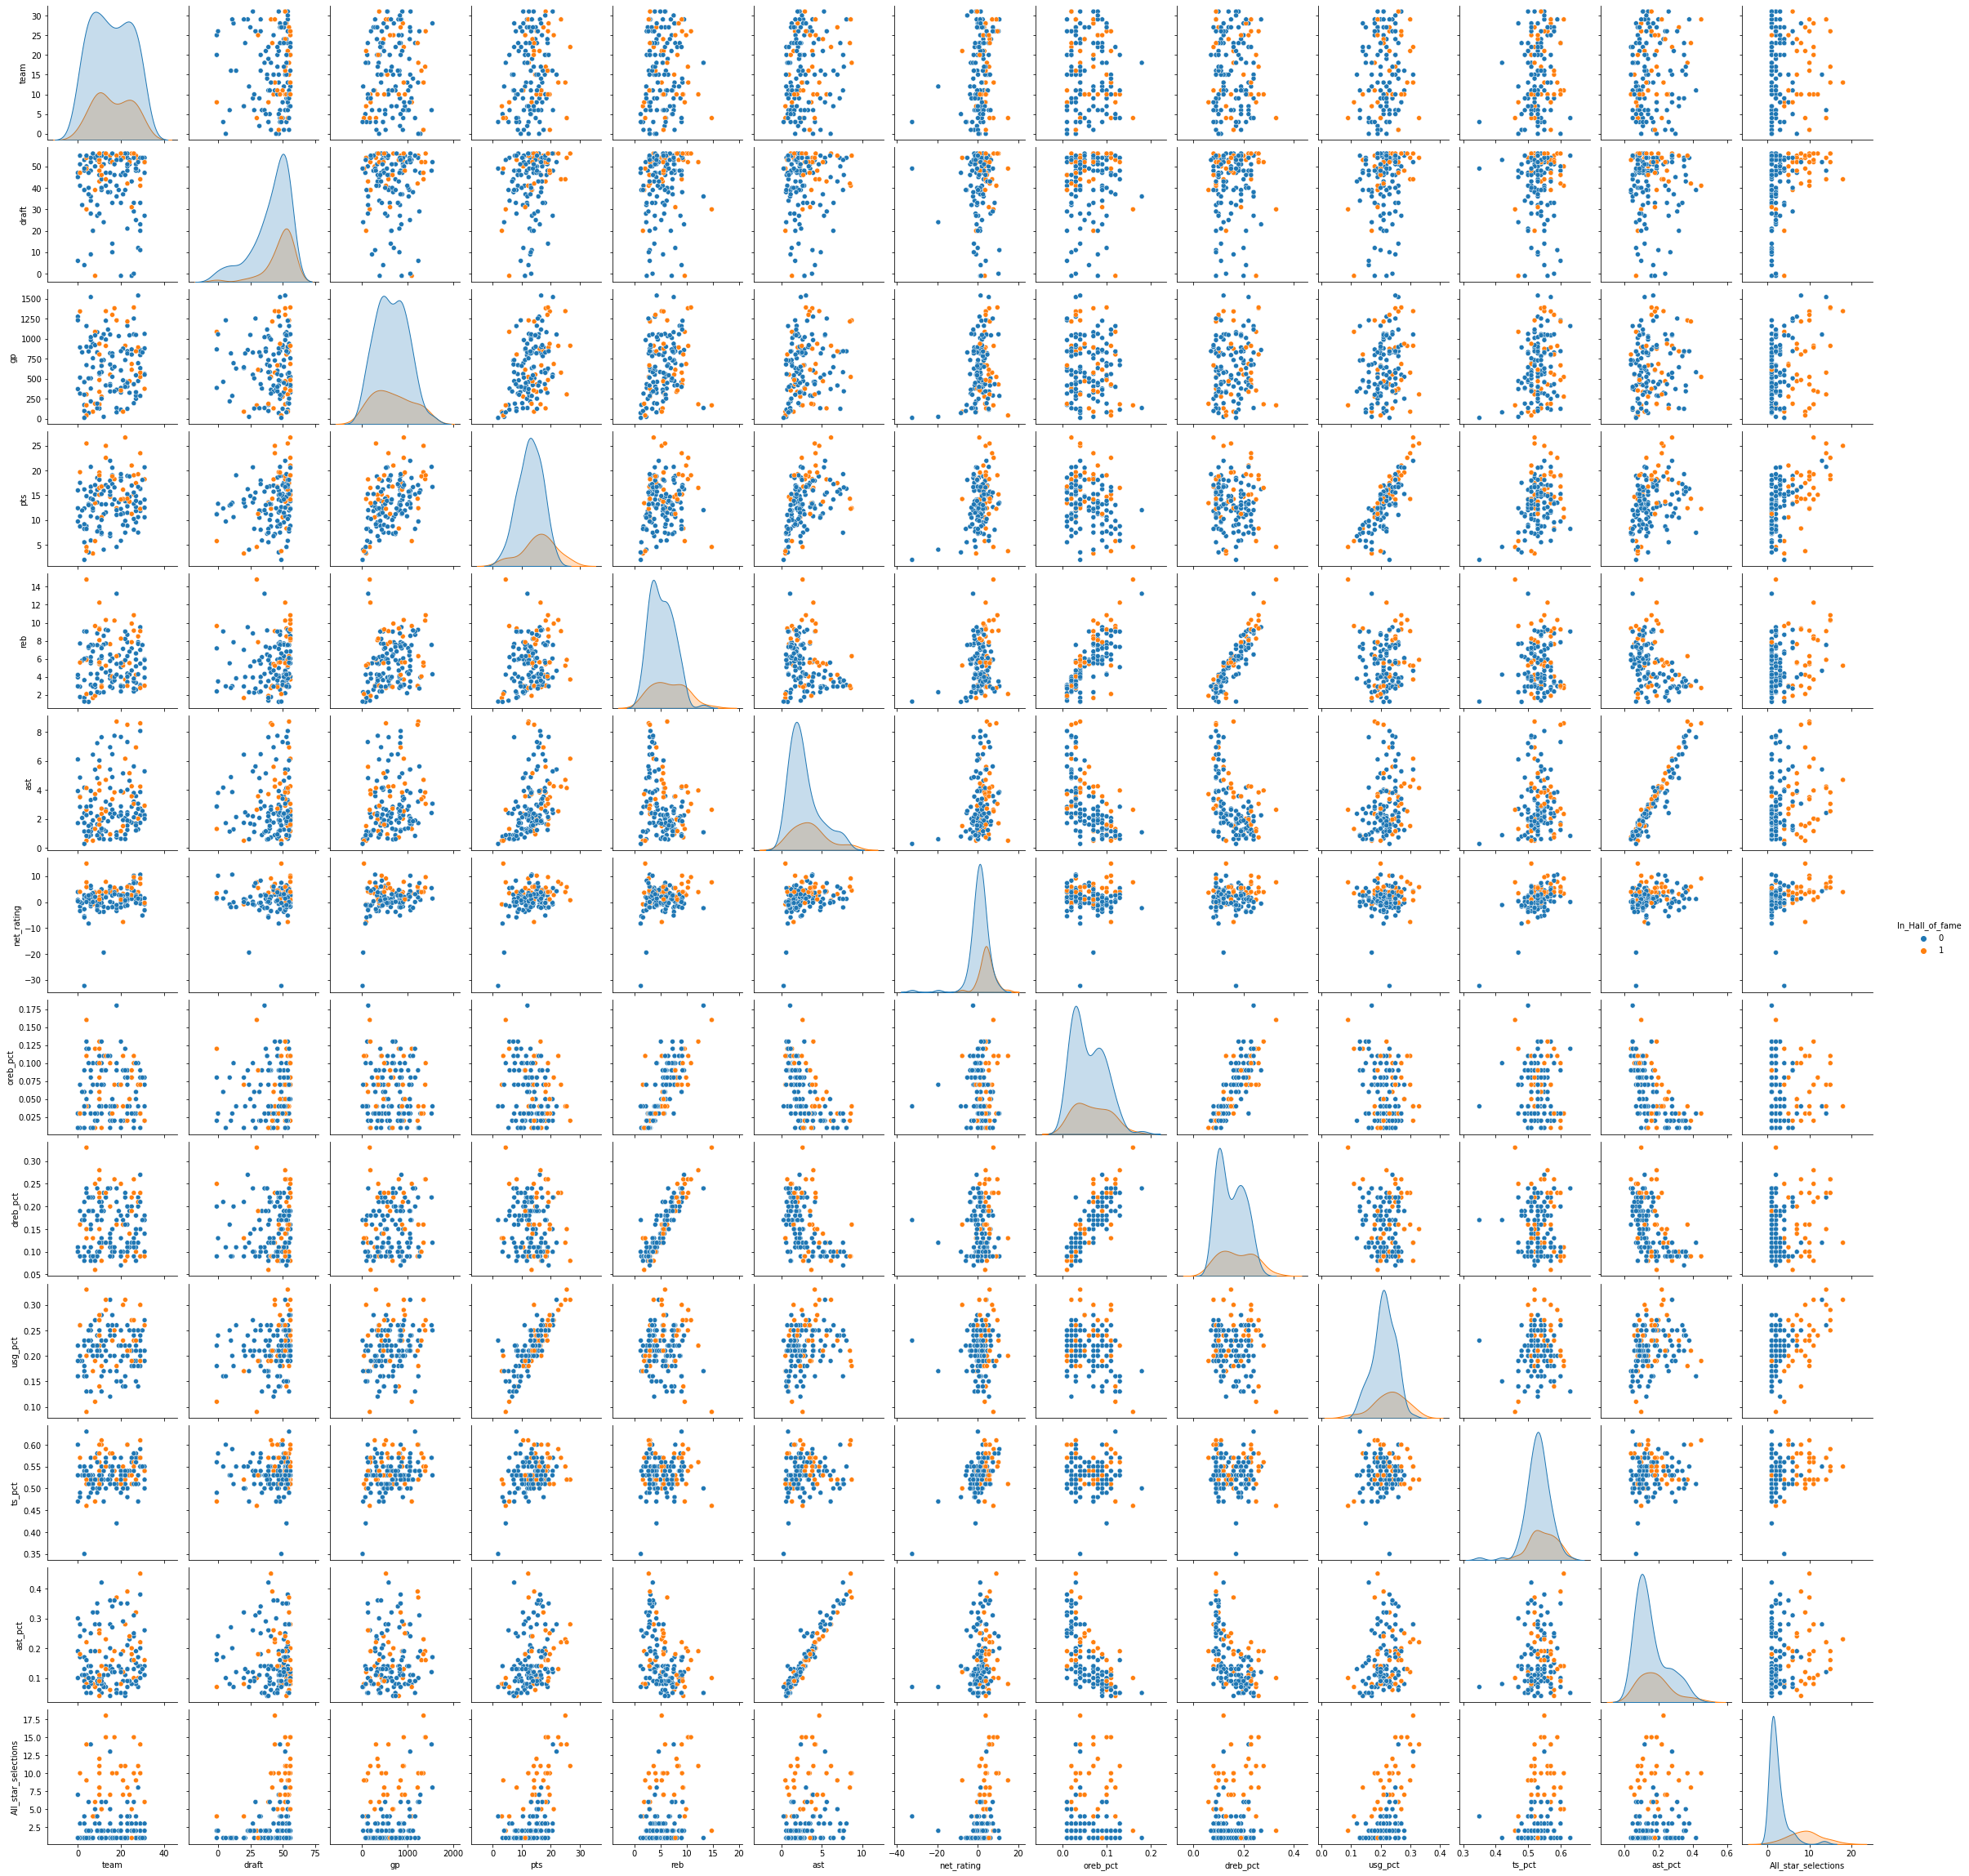

In [ ]:
sns.pairplot(final_data, hue=predict_label)

### Correlation heatmaps
Due to the detection of significant correlations between features in the pairplot above, further analysis was required to eliminate these correlations. The heatmaps provide a cleaner visualization along with discrete values representing the level of correlation between features. These values allow for a clear threshhold to determine which correlations need to be eliminated. <br>
The second heatmap shows the best results in terms of limited correlation, so the features to remove from the data are
- dreb_pct
- oreb_pct
- ast
- usg_pct

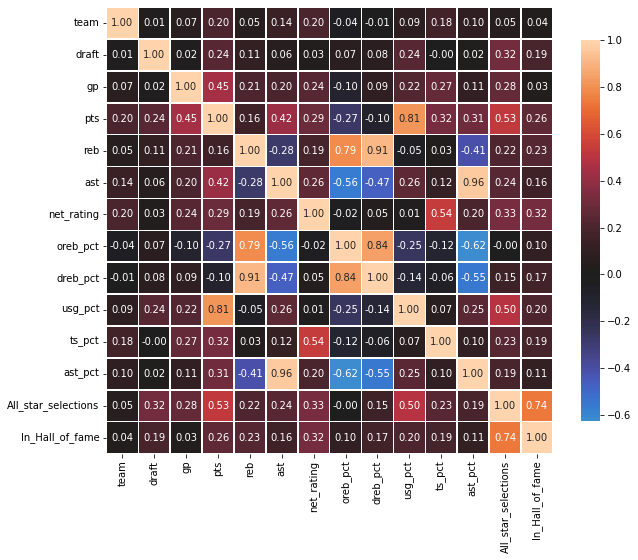

In [ ]:
# Source: https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(final_data.corr(), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show()

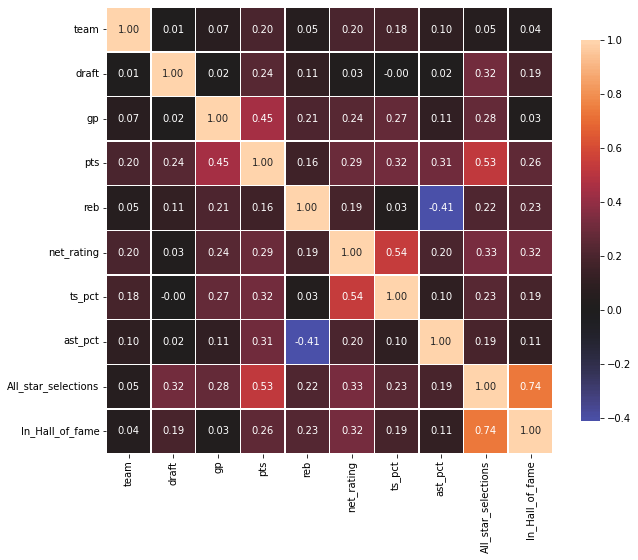

In [ ]:
# Source: https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(final_data.drop(columns=['dreb_pct', 'oreb_pct', 'ast', 'usg_pct']).corr(), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show()

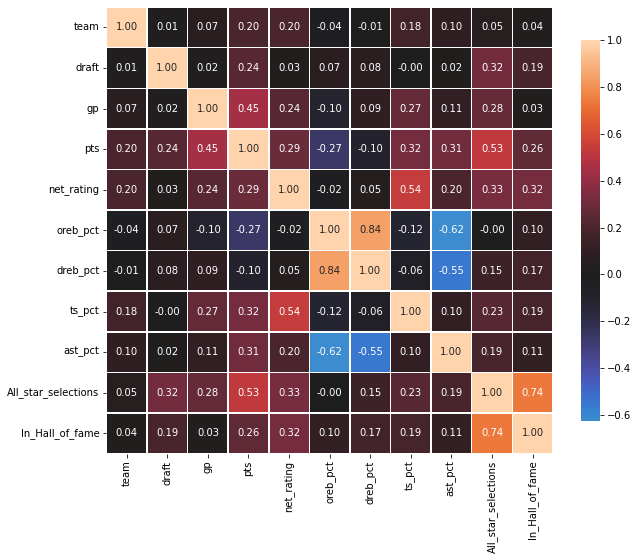

In [ ]:
# Source: https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(final_data.drop(columns=['reb', 'ast', 'usg_pct']).corr(), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show()

### Histogram
This provides further insight on the distribution of individual features against the different values of the prediction label (Hall of Famer). This was done because the data description above showed an odd distribution for the net rating feature at first glance, so a more detailed look at the distribution seemed appropriate. However, in the end, the outliers in the feature didn't seem like they would cause much harm to the model as enough of the expected distribution was present in both possible labels, so those data points were kept in the data set.

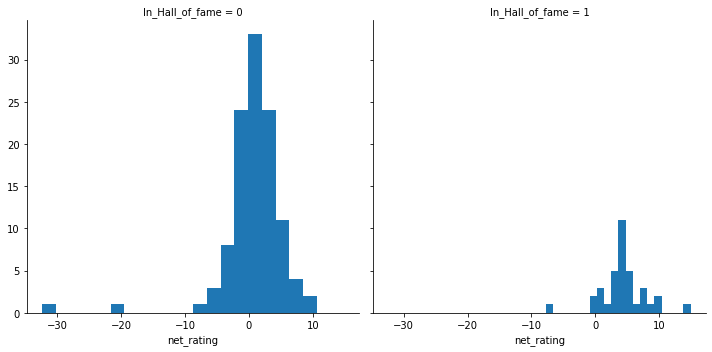

In [ ]:
# Histogram for net_rating

g = sns.FacetGrid(final_data, col=predict_label, height=5)
g.map(plt.hist, 'net_rating', bins=20)

### Pie charts
These show the distribution of values in categorical features. The prediction label was treated as categorical because although the 0 and 1 are numerical, they represent possible classes, not continuous values. The cardinality of the College feature led to its removal from the dataset, as the feature didn't feel important enough to keep at the expense of high dimensionality.

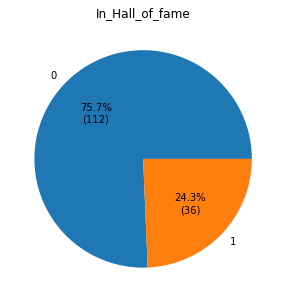

In [ ]:
# Source: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=final_data[predict_label].value_counts(), 
       labels=final_data[predict_label].value_counts().index,
       autopct=lambda pct: '{:.1f}%\n({:d})'.format(pct, int(len(final_data)*pct/100.)),
       textprops=dict(color="black"))

ax.set_title(predict_label)

plt.show()

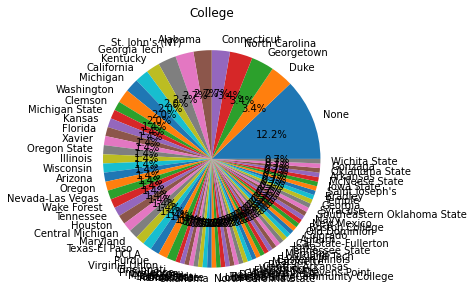

In [ ]:
# Pie charts for college
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=final_data['college'].value_counts(), 
       labels=final_data['college'].value_counts().index,
       autopct='%1.1f%%', textprops=dict(color="black"))

ax.set_title('College')

plt.show()

### PCA

In [ ]:
# PCA
pca = PCA()
pca.fit(final_data.drop(columns=['player_name', 'college', predict_label]))
print(pca.explained_variance_ratio_)

[9.97379939e-01 1.53598620e-03 6.31478096e-04 2.03121636e-04
 1.19305619e-04 6.35710146e-05 4.99075741e-05 1.66752915e-05
 7.12634285e-09 4.60313119e-09 1.98958531e-09 1.65343917e-09
 5.40089728e-10]


## Data preparation for model
Split data into train and test X and y data sets

In [12]:
# Final data set (player_name is kept for reference to each of the entries)
final_data = final_data.drop(columns=['college', 'dreb_pct', 'oreb_pct', 'ast', 'usg_pct'])
final_data.head()

,player_name,team,draft,gp,pts,reb,net_rating,ts_pct,ast_pct,All_star_selections,In_Hall_of_fame
0,A.C. Green,6,34,379,5.86,6.19,-1.58,0.49,0.05,1,0
2,Allan Houston,20,46,602,18.56,3.06,0.58,0.54,0.13,2,0
3,Allen Iverson,22,56,914,26.67,3.71,0.74,0.52,0.28,11,1
4,Alonzo Mourning,15,55,553,14.68,7.63,5.40,0.58,0.06,7,1
5,Amar'e Stoudemire,23,48,846,18.91,7.84,2.37,0.60,0.07,6,0


In [14]:
use_data = final_data.drop(columns=['player_name'])

X_final, y_final = use_data.drop(columns=[predict_label]), use_data[predict_label]

min_max = preprocessing.MinMaxScaler()
temp = X_final.values
temp_cols = X_final.columns
temp_scaled = min_max.fit_transform(temp)
X_final = pd.DataFrame(temp_scaled, columns=temp_cols)

In [15]:
X_final.head()

,team,draft,gp,pts,reb,net_rating,ts_pct,ast_pct,All_star_selections
0,0.193548,0.614035,0.239529,0.158512,0.365782,0.651438,0.500000,0.024390,0.000000
1,0.645161,0.824561,0.385471,0.672058,0.134956,0.697124,0.678571,0.219512,0.058824
2,0.709677,1.000000,0.589660,1.000000,0.182891,0.700508,0.607143,0.585366,0.588235
3,0.483871,0.982456,0.353403,0.515164,0.471976,0.799069,0.821429,0.048780,0.352941
4,0.741935,0.859649,0.545157,0.686211,0.487463,0.734983,0.892857,0.073171,0.294118


In [16]:
y_final.head()

0    0
2    0
3    1
4    1
5    0
Name: In_Hall_of_fame, dtype: int64

# Task 3: Logistic Regression Model

In [75]:
# Task 3: logistic regression

X = X_final.to_numpy()
Y = np.reshape(y_final.to_numpy(), (148, 1))
print(X.shape, Y.shape)

(148, 9) (148, 1)


In [76]:
w = np.random.normal(scale=0.1, size=(9, 1))
b = np.zeros((148, 1))
n = 148
sigmoid = lambda x: 1 / (1 + math.exp(-x))

## Batch Gradient Descent

In [ ]:
learning_rate = 0.1

# Converges after 10 iterations
for _ in range(10):
    A = np.vectorize(sigmoid)(np.dot(X, w) + b)
    cost = -1/n * np.sum(Y * np.log(A) + (1-Y) * (np.log(1-A)))
    dw = np.dot(X.T, (A-Y))/n
    db = np.sum(A-Y)/n

    w = w - learning_rate*dw
    b = b - learning_rate*db

In [29]:
# Accuracy measure
get_acc = lambda y, y_hat: (148 - np.count_nonzero(np.round(y_hat, decimals=0) - y)) / 148

Y_hat = np.vectorize(sigmoid)(np.dot(X, w) + b)
print(get_acc(Y, Y_hat))
#print(np.round(Y_hat, decimals=0))

0.7567567567567568


## Stochastic Gradient Descent

In [36]:
print(X[0].T.shape)

(9,)


In [77]:
learning_rate = 0.1

# Converges after 10 iterations
for _ in range(10):
    np.random.shuffle(X)
    for i in range(148):
        a = np.vectorize(sigmoid)(np.dot(X[i], w) + b[i])
        # print(np.dot(np.reshape(X[i].T, (9, 1)), (a-Y[i])).shape)
        # break
        cost = -1/n * np.sum(Y[i] * np.log(a) + (1-Y[i]) * (np.log(1-a)))
        dw = np.dot(np.reshape(X[i].T, (9, 1)), np.reshape(a-Y[i], (1, 1)))/n
        db = (a-Y[i])/n

        w = w - learning_rate*dw
        b[i] = b[i] - learning_rate*db

In [78]:
Y_hat = np.vectorize(sigmoid)(np.dot(X, w) + b)
print(get_acc(Y, Y_hat))

0.7567567567567568


# Task 4: Optimization Algorithms
Chosen algorithms are Adam and Adamax

In [22]:
import tensorflow as tf

## Adam optimizer

In [ ]:
# Task 4: optimizers
# Adam optimizer, adamax optimizer

adam_opt = tf.keras.optimizers.Adam(learning_rate=0.1)

A = tf.Variable(np.vectorize(sigmoid)(np.dot(X, w) + b))
Y = tf.cast(tf.convert_to_tensor(Y), dtype=tf.float64)
# A = tf.convert_to_tensor(A)
# A = tf.Variable(A)
loss = lambda: (-1/n) * tf.math.reduce_sum(Y * tf.math.log(A) + (1-Y) * (tf.math.log(1-A)))

step_count = adam_opt.minimize(loss, [A]).numpy()
# The first step is `-learning_rate*sign(grad)`
A


In [60]:
print(get_acc(Y, A))
#print(np.round(Y_hat, decimals=0))

1.0


## Adamax optimizer

In [ ]:
adamax_opt = tf.keras.optimizers.Adamax(learning_rate=0.1)

A = tf.Variable(np.vectorize(sigmoid)(np.dot(X, w) + b))
Y = tf.cast(tf.convert_to_tensor(Y), dtype=tf.float64)
# A = tf.convert_to_tensor(A)
# A = tf.Variable(A)
loss = lambda: (-1/n) * tf.math.reduce_sum(Y * tf.math.log(A) + (1-Y) * (tf.math.log(1-A)))

step_count = adamax_opt.minimize(loss, [A]).numpy()
# The first step is `-learning_rate*sign(grad)`
A

In [64]:
print(get_acc(Y, A))

0.9932432432432432


## Conclusion + Result Analysis



Logistic regression was run with Batch Gradient Descent, Stochastic Gradient Descent, Batch Gradient Descent using the Adam optimizer, and Batch Gradient Descent using the Adamax optimizer. Both runs without any optimization algorithm converged with the same training accuracy: ~76%. With Adam optimizer, the model converged with a training accuracy of 100%, while the Adamax optimizer led to a training accuracy of ~99%. Testing accuracy wasn't measured due to the relatively small size of the data set, meaning that splitting it further into training and testing sets could lead to an inaccurate model. <br>
Based on these results, utilizing an optimization algorithm proves to improve the model greatly for solving this problem. This is most likely because of the impact of the learning rate, as when a lower learning rate was first chosen, the model performed significantly worse, meaning that the optimization algorithms' impact on the learning rate is significant enough to make the model its best version possible.